In [6]:
import numpy as np
from PIL import Image as im
import matplotlib.pyplot as plt
import sklearn.datasets as datasets

centers = [[0, 0], [2, 2], [-3, 2], [2, -4]]
X, _ = datasets.make_blobs(n_samples=300, centers=centers, cluster_std=1, random_state=0)

class KMeans():

    def __init__(self, data, k, init_method, manual):
        """data:        [array] The dataset                                    
           k:           [int] number of clusters                            
           init_method: [int] which way to initilize the data, where 0 = rand, 1 = FF, 2 = KM++, 3 = Manual
           manual:      [array] only specified if init_method = 3, gives the centroid coordinates
        """
        self.data = data
        self.k = k
        self.init_method = init_method
        self.manual = manual
        self.assignment = [-1 for _ in range(len(data))]
        self.snaps = []

    def snap(self, centers):
        TEMPFILE = "temp.png"

        fig, ax = plt.subplots()
        ax.scatter(X[:, 0], X[:, 1], c=self.assignment)
        ax.scatter(centers[:,0], centers[:, 1], c='r')
        fig.savefig(TEMPFILE)
        plt.close()
        self.snaps.append(im.fromarray(np.asarray(im.open(TEMPFILE))))

    def isunassigned(self, i):
        return self.assignment[i] == -1

    def initialize(self):
        if self.init_method == 0:
            return self.random()
        elif self.init_method == 1:
            return self.Farthest_First()
        elif self.init_method == 2:
            return self.KMeansPlusPlus()
        elif self.init_method == 3:
            return self.Manual
        else:
            print("error")

    def make_clusters(self, centers):
        for i in range(len(self.assignment)):
            for j in range(self.k):
                if self.isunassigned(i):
                    self.assignment[i] = j
                    dist = self.dist(centers[j], self.data[i])
                else:
                    new_dist = self.dist(centers[j], self.data[i])
                    if new_dist < dist:
                        self.assignment[i] = j
                        dist = new_dist


    def compute_centers(self):
        centers = []
        for i in range(self.k):
            cluster = []
            for j in range(len(self.assignment)):
                if self.assignment[j] == i:
                    cluster.append(self.data[j])
            centers.append(np.mean(np.array(cluster), axis=0))

        return np.array(centers)

    def unassign(self):
        self.assignment = [-1 for _ in range(len(self.data))]

    def are_diff(self, centers, new_centers):
        for i in range(self.k):
            if self.dist(centers[i], new_centers[i]) != 0:
                return True
        return False

    def dist(self, x, y):
        # Euclidean distance
        return sum((x - y)**2) ** (1/2)

    def TwoDdist(self, a, b):
        x_diff = (self.data[a][0] - self.data[b][0])**2
        y_diff = (self.data[a][1] - self.data[b][1])**2
        return (x_diff + y_diff)**.5

    def lloyds(self):
        centers = self.initialize()
        print(centers)
        self.make_clusters(centers)
        new_centers = self.compute_centers()
        self.snap(new_centers)
        while self.are_diff(centers, new_centers):
            self.unassign()
            centers = new_centers
            self.make_clusters(centers)
            new_centers = self.compute_centers()
            self.snap(new_centers)
        return

    # The following are the differenti initilization methods we need to implment:

    def random(self):
        return self.data[np.random.choice(len(self.data) - 1, size=self.k, replace=False)]
    
    def Farthest_First(self):
        # loop ids
        loops = np.linspace(0,self.k-1,self.k)
        # contains the indicies of the k centers
        center_indicies = np.linspace(0,self.k-1,self.k)
        # each inted contrains the sum of total distances to all other centers
        center_lengths = np.linspace(0,self.k-1,self.k)

        temp_length = 0
        temp_shorter_length = -1
        temp_shorter_index = -1

        # Initilizing ceneter lengths:
        for i in loops:
            for j in loops:
                center_lengths[i] += self.TwoDdist(i,j)

        # Checking all other points
        for i in range(self.k,len(self.data)):

            # Computing sum of lengths for candidate point:
            for j in loops:
                temp_length += self.TwoDdist(i,j)

            # Seeing is Candidate point is father than any of the current points
            for j in loops:
                # We found a point where the candidate is farther
                if center_lengths[j] < temp_length:
                    # If this is the only one so far, mark it
                    if temp_shorter_index == -1:
                        temp_shorter_index = j
                        temp_shorter_length = center_lengths[j]
                    # If we already found another shorter point, compare with of the 2 is shorter and discard
                    else:
                        if temp_shorter_length > center_lengths[j]:
                            temp_shorter_index = j
                            temp_shorter_length = center_lengths[j]

            # If shorter point found, do the replacement
            if temp_shorter_index != -1:
                center_indicies[temp_shorter_index] = i
                center_lengths[temp_shorter_index] = temp_length 
        
        # Populating Return array
        centers  = [[0,0]]*self.k
        for i in loops:
           centers[i][0] = self.data[center_indicies[i]][0]
           centers[i][1] = self.data[center_indicies[i]][1]
        
        return centers

    def KMeansPlusPlus(self):
        # Pick a point a random uniformly at random
        centers = [0]*self.k
        centers[0] = np.random.uniform(0,len(self.data)-1)

        # Compute the squared distances for all data points to the nearest center 
        D = [[0,0]] * len(self.data) # [distance, data index]
        distance_sum = 0
        
        for i in range(0, len(self.data)):
            if i != centers[0]:
                D[i][0] = self.TwoDdist(i,centers[0]) ** 2
                D[i][1] = i
                distance_sum += D[i][0]

        # Sort by distance
        D.sort(key=lambda x: x[1])

        # Pick the next center using weighted probability of the squared distance to the nearest center
        distance_traveled = 0
        rand_num = np.random.uniform(0,distance_sum)
        for i in D:
            distance_traveled += i[0]
            if rand_num <= distance_traveled:
                centers[1] = i[1]

        for i in range(1, self.k):
            for j in range(0, len(self.data)):
              polarbear = 1
        # Repeat for k centers
        return 1

    def Manual(self):
        return self.manual


In [7]:
kmeans = KMeans(X, 4, 0, None)
kmeans.lloyds()
images = kmeans.snaps

images[0].save(
    'kmeans.gif',
    optimize=False,
    save_all=True,
    append_images=images[1:],
    loop=0,
    duration=500
)


[[ 2.39904635 -0.77259276]
 [ 1.78305043 -3.55460675]
 [ 0.72031083 -4.5854312 ]
 [ 0.8644362  -0.74216502]]


In [75]:
print([[0,0]]*3)

[[0, 0], [0, 0], [0, 0]]


<class 'numpy.ndarray'>


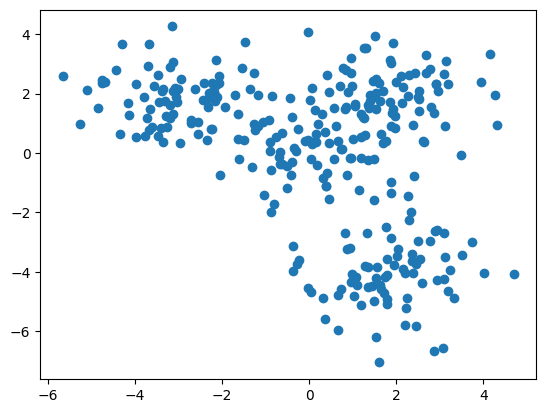

In [9]:

x, y = np.hsplit(X,2)
plt.scatter(x,y)
print(type(X))
